The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 自然语言推理：使用注意力
:label:`sec_natural-language-inference-attention`

我们在 :numref:`sec_natural-language-inference-and-dataset` 中引入了自然语言推理任务和 SNLI 数据集。鉴于许多基于复杂而深入的体系结构的模型，Parikh 等人提议用注意机制来解决自然语言推理问题，并称之为 “可分解的注意力模型” :cite:`Parikh.Tackstrom.Das.ea.2016`。这将产生一个没有循环或卷积层的模型，从而在 SNLI 数据集上以更少的参数获得当时最佳结果。在本节中，我们将介绍并实施这种基于注意力的方法（使用 MLP）进行自然语言推断，如 :numref:`fig_nlp-map-nli-attention` 所述。 

![This section feeds pretrained GloVe to an architecture based on attention and MLPs for natural language inference.](../img/nlp-map-nli-attention.svg)
:label:`fig_nlp-map-nli-attention`

## 模型

比保留前提和假设中令牌的顺序更简单，我们只需将一个文本序列中的令牌与另一个标记中的每个令牌对齐，反之亦然，然后比较和聚合这些信息以预测前提和假设之间的逻辑关系。与机器翻译中源句子和目标句子之间的令牌对齐类似，前提和假设之间的代币对齐可以通过注意机制整齐地实现。 

![Natural language inference using attention mechanisms.](../img/nli-attention.svg)
:label:`fig_nli_attention`

:numref:`fig_nli_attention` 描述了使用注意机制的自然语言推理方法。在高层次上，它包括三个联合训练的步骤：参加、比较和聚合。我们将在下面一步一步地说明它们。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


### 参加

第一步是将一个文本序列中的标记与另一个序列中的每个标记对齐。假设前提是 “我确实需要睡觉”，假设是 “我累了”。由于语义上的相似性，我们可能希望将假设中的 “i” 与前提中的 “i” 对齐，并将假设中的 “疲倦” 与前提中的 “睡眠” 对齐。同样，我们可能希望将假设中的 “i” 与假设中的 “i” 对齐，并将前提中的 “需要” 和 “睡眠” 与假设中的 “疲倦” 对齐。请注意，这种对齐方式是使用加权平均值的 *soft*，理想情况下，较大的权重与待对齐的代币相关联。为了便于演示，:numref:`fig_nli_attention` 以 * 硬 * 的方式显示了这种对齐。 

现在我们使用注意机制更详细地描述软对齐。用 $\mathbf{A} = (\mathbf{a}_1, \ldots, \mathbf{a}_m)$ 和 $\mathbf{B} = (\mathbf{b}_1, \ldots, \mathbf{b}_n)$ 表示前提和假设，其代币数量分别为 $m$ 和 $n$，其中 $\mathbf{a}_i, \mathbf{b}_j \in \mathbb{R}^{d}$（$i = 1, \ldots, m, j = 1, \ldots, n$）是 $d$ 维字矢量。对于软对齐，我们将注意力权重 $e_{ij} \in \mathbb{R}$ 计算为 

$$e_{ij} = f(\mathbf{a}_i)^\top f(\mathbf{b}_j),$$
:eqlabel:`eq_nli_e`

其中函数 $f$ 是以下 `mlp` 函数中定义的 MLP。$f$ 的输出维度由 `num_hiddens` 参数 `mlp` 指定。


In [2]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

应该强调的是，在 :eqref:`eq_nli_e` $f$ 中将输入 $\mathbf{a}_i$ 和 $\mathbf{b}_j$ 分别接收输入 $\mathbf{a}_i$ 和 $\mathbf{b}_j$，而不是将其中一对作为输入。这个 * 分解 * 技巧导致只有 $m + n$ 个应用程序（线性复杂度）为 $f$，而不是 $mn$ 应用程序（二次复杂度）。 

对 :eqref:`eq_nli_e` 中的注意权重进行规范化，我们计算假设中所有令牌矢量的加权平均值，以获得与前提中索引 $i$ 的令牌轻微对齐的假设的表示： 

$$
\boldsymbol{\beta}_i = \sum_{j=1}^{n}\frac{\exp(e_{ij})}{ \sum_{k=1}^{n} \exp(e_{ik})} \mathbf{b}_j.
$$

同样，我们计算假设中索引 $j$ 的每个令牌的前提令牌的软对齐： 

$$
\boldsymbol{\alpha}_j = \sum_{i=1}^{m}\frac{\exp(e_{ij})}{ \sum_{k=1}^{m} \exp(e_{kj})} \mathbf{a}_i.
$$

下面我们定义了 `Attend` 类，用于计算假设（`beta`）与输入前提 `A` 和前提软对齐（`alpha`）与输入假设 `B` 的假设（`beta`）与输入假设 `B` 的软对齐。


In [3]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

### 比较

在下一步中，我们将一个序列中的令牌与与该令牌轻微对齐的另一个序列进行比较。请注意，在软对齐中，来自一个序列的所有令牌（尽管注意力重量可能不同）将与另一个序列中的令牌进行比较。为了便于演示，:numref:`fig_nli_attention` 以 * 硬 * 的方式将令牌与对齐的代币配对。例如，假设出席步骤确定前提中的 “需要” 和 “睡眠” 都与假设中的 “疲倦” 一致，那么将对 “疲倦-需要睡眠” 进行比较。 

在比较步骤中，我们将来自一个序列的令牌串联（运算符 $[\cdot, \cdot]$）和另一个序列中的对齐令牌输入函数 $g$（MLP）： 

$$\mathbf{v}_{A,i} = g([\mathbf{a}_i, \boldsymbol{\beta}_i]), i = 1, \ldots, m\\ \mathbf{v}_{B,j} = g([\mathbf{b}_j, \boldsymbol{\alpha}_j]), j = 1, \ldots, n.$$

:eqlabel:`eq_nli_v_ab` 

在 :eqref:`eq_nli_v_ab` 中，$\mathbf{v}_{A,i}$ 是前提中令牌 $i$ 与所有与令牌 $i$ 轻对齐的假设令牌之间的比较；而 $\mathbf{v}_{B,j}$ 是假设中令牌 $j$ 与与令牌 $j$ 轻一致的所有前提令牌之间的比较。以下 `Compare` 类定义了例如比较步骤。


In [4]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

### 聚合

手头上有两组比较向量 $\mathbf{v}_{A,i}$（$i = 1, \ldots, m$）和 $\mathbf{v}_{B,j}$（$j = 1, \ldots, n$），在最后一步中，我们将汇总这些信息以推断逻辑关系。我们首先总结两套： 

$$
\mathbf{v}_A = \sum_{i=1}^{m} \mathbf{v}_{A,i}, \quad \mathbf{v}_B = \sum_{j=1}^{n}\mathbf{v}_{B,j}.
$$

接下来，我们将两个总结结果的串联提供到函数 $h$（MLP）中，以获取逻辑关系的分类结果： 

$$
\hat{\mathbf{y}} = h([\mathbf{v}_A, \mathbf{v}_B]).
$$

聚合步骤在以下 `Aggregate` 类中定义。


In [5]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

### 把所有东西放在一起

通过将参加、比较和汇总步骤放在一起，我们定义了可分解的注意力模型来共同训练这三个步骤。


In [6]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

## 训练和评估模型

现在我们将在 SNLI 数据集上训练和评估定义的可分解注意力模型。我们首先阅读数据集。 

### 读取数据集

我们使用 :numref:`sec_natural-language-inference-and-dataset` 中定义的函数下载并读取 SNLI 数据集。批次大小和序列长度分别设置为 $256$ 和 $50$。


In [7]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples


read 9824 examples


### 创建模型

我们使用预先训练的 100 维 Glove 嵌入来表示输入令牌。因此，我们在 :eqref:`eq_nli_e` 中将向量 $\mathbf{a}_i$ 和 $\mathbf{b}_j$ 的维度预定义为 100。:eqref:`eq_nli_e` 中的功能 $f$ 和 :eqref:`eq_nli_v_ab` 中的 $g$ 和 $g$ 的输出维度设置为 200。然后我们创建一个模型实例，初始化其参数，然后加载 GLOVE 嵌入来初始化输入令牌的向量。


In [8]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

### 训练和评估模型

与 :numref:`sec_multi_gpu` 中接收单个输入（例如文本序列（或图像）的 `split_batch` 函数不同，我们定义了 `split_batch_multi_inputs` 函数来接收多个输入，例如前提和假设。


现在我们可以在 SNLI 数据集上训练和评估模型。


loss 0.492, train acc 0.807, test acc 0.830
19131.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


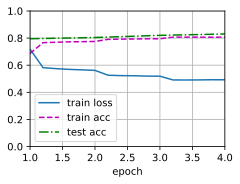

In [9]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### 使用模型

最后，定义预测函数以输出一对前提和假设之间的逻辑关系。


In [10]:
#@save
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

我们可以使用训练有素的模型来获取样本对句子的自然语言推断结果。


In [11]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

## 摘要

* 可分解的注意力模型由三个步骤组成，用于预测前提和假设之间的逻辑关系：参与、比较和聚合。
* 通过注意机制，我们可以将一个文本序列中的令牌与另一个标记中的每个令牌对齐，反之亦然。使用加权平均值，这种对齐是软的，理想情况下，较大的权重与待对齐的代币相关联。
* 在计算注意力权重时，分解技巧会导致比二次复杂性更加理想的线性复杂性。
* 我们可以使用预训练的单词矢量作为下游自然语言处理任务（例如自然语言推断）的输入表示。

## 练习

1. 使用超参数的其他组合训练模型。你能在测试套装上获得更好的准确性吗？
1. 自然语言推断的可分解注意力模型的主要缺点是什么？
1. 假设我们想要获得任何一对句子的语义相似度（例如，介于 0 到 1 之间的连续值）。我们应该如何收集和标记数据集？你能设计一个具有注意力机制的模型吗？


[Discussions](https://discuss.d2l.ai/t/1530)
